In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.linear_model import LinearRegression
%matplotlib inline

# songs voted on piki

In [2]:
interactions_from_selected_users_df=pd.read_csv('data.csv')
len(interactions_from_selected_users_df)

353891

# most played artists in their Spotify

In [23]:
piki_spotify_imports = pd.read_csv("piki_user_songs.csv",engine='python') 
mkt_share=piki_spotify_imports.groupby('pop_decile')['pop_decile'].count()/piki_spotify_imports.count()[0] #.sort_values(ascending=False)
artists=[]
pop_deciles=[]
for index, song in piki_user_songs.iterrows():
    artists.append(song['artist'])
    pop_deciles.append(song['pop_decile'])

0.802359617145833


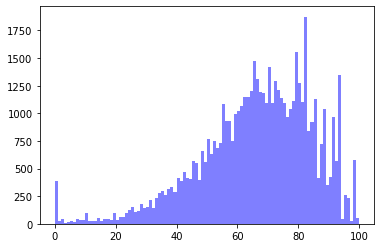

In [25]:
n, bins, patches = plt.hist(pop_deciles, 100, facecolor='blue', alpha=0.5)

# A few facts about people's tastes

# popular songs are liked more (for spotify popularity >60)

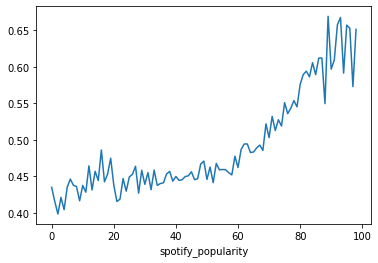

In [3]:
interactions_from_selected_users_df.groupby(['spotify_popularity']).mean()['liked'].plot()

# Popularity of rated songs is normally distributed around 50 popularity

# Spotify popularity 60 = 1,000,000 monthly listeners

# Spotify popularity 50 = 300,000 monthly listeners

songs voted on piki are on average less popular than songs streamed on spotify

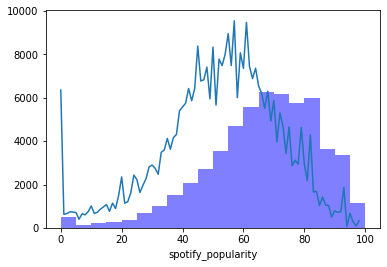

In [29]:
piki_spotify_imports = pd.read_csv("piki_user_songs.csv",engine='python') 
mkt_share=piki_spotify_imports.groupby('pop_decile')['pop_decile'].count()/piki_spotify_imports.count()[0] #.sort_values(ascending=False)
artists=[]
pop_deciles=[]
for index, song in piki_user_songs.iterrows():
    artists.append(song['artist'])
    pop_deciles.append(song['pop_decile'])

interactions_from_selected_users_df.groupby(['spotify_popularity']).count()['liked'].plot()
n, bins, patches = plt.hist(pop_deciles, 20, facecolor='blue', alpha=0.5)

# song quality distribution (% likes)

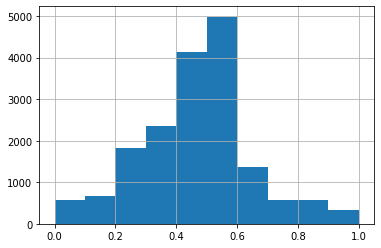

In [10]:
interactions_from_selected_users_df.groupby(['song_id']).mean()['liked'].sort_values().hist()

# user pikiness distribution (% likes)

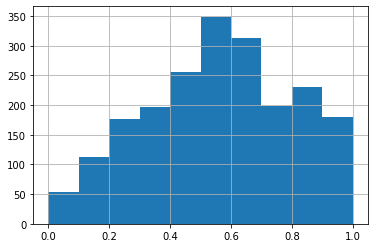

In [18]:
interactions_from_selected_users_df.groupby(['user_id']).mean()['liked'].sort_values().hist()

In [5]:
interactions_from_selected_users_df.head()

,user_id,song_id,liked,spotify_popularity
0,1129348,183,1,66
1,1129348,201,0,88
2,1129348,274,0,72
3,1129348,422,1,88
4,1129348,511,1,76


# Split into training and testing set

In [6]:
train_df, test_df = train_test_split(interactions_from_selected_users_df,
                                   stratify=interactions_from_selected_users_df['user_id'], 
                                   test_size=0.50)
print('# interactions on Train set: %d' % len(train_df))
print('# interactions on Test set: %d' % len(test_df))

# interactions on Train set: 176945
# interactions on Test set: 176946


In [472]:
# old  --- deprecated
# compute metrics for each user 
# and then average metrics over all users
class ModelEvaluator:

    def evaluate_model_for_user(self, model, user_id):

        user_likes_df=test_df[test_df['user_id']==user_id][['liked','song_id','spotify_popularity']].set_index('song_id').sort_index()['liked']

        song_list=test_df[test_df['user_id']==user_id].set_index('song_id')['spotify_popularity'].sort_index()
        user_recs_df = model.classify_items(user_id,song_list).sort_index()
        kappa=metrics.cohen_kappa_score(user_likes_df,user_recs_df)
        accuracy_score=metrics.accuracy_score(user_likes_df,user_recs_df)

        if (sum(user_likes_df==1)>0) & (sum(user_recs_df==1)>0):
            # note piki users will not be considered
            model_pop=song_list[user_recs_df==1].mean() 
            my_pop=song_list[user_likes_df==1].mean()
            pop_bias=model_pop-my_pop
        else:
            pop_bias=0

        user_metrics = {'user_id':user_id,'accuracy':accuracy_score,'kappa':kappa, 'popularity_bias':pop_bias}
        return user_metrics

    def evaluate_model(self, model):
        people_metrics = []
        for user_id in test_df.groupby('user_id').mean().index:
            person_metrics = self.evaluate_model_for_user(model, user_id)  
            people_metrics.append(person_metrics)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('accuracy', ascending=False)
        
        global_accuracy= detailed_results_df['accuracy'].sum() / float(detailed_results_df['accuracy'].count())
        global_kappa= detailed_results_df['kappa'].sum() / float(detailed_results_df['accuracy'].count())
        global_pop_bias= detailed_results_df['popularity_bias'].sum() / float(detailed_results_df['accuracy'].count())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'accuracy': global_accuracy,
                          'kappa': global_kappa,
                            'pop_bias':global_pop_bias}    
        return global_accuracy,global_kappa,global_pop_bias,global_metrics, detailed_results_df

model_evaluator = ModelEvaluator()

In [19]:
# fill the predictions dataframe for the test set 
# then compute metrics for the entire test set
class GlobalModelEvaluator:

    def __init__(self, test_df):
        self.test_df = test_df
        self.predictions_df = pd.DataFrame(columns = ['user_id','song_id','liked'],dtype='int') 
        
    def evaluate_model_for_user(self, model, user_id):
        # get list of songs to be classified
        song_list=self.test_df[self.test_df['user_id']==user_id].set_index('song_id') #.sort_index()
        # ask the model to classify
        user_recs_df = model.classify_items(user_id,song_list) #.sort_index()
        user_recs_df=user_recs_df.reset_index(drop=False)
        user_recs_df['user_id']=user_id
        # append the classification to the predictions dataframe
        self.predictions_df=self.predictions_df.append(user_recs_df,ignore_index = True)
        return user_recs_df

    def evaluate_model(self, model):
        people_metrics = []
        # loop through all users and classify test songs
        for user_id in self.test_df.groupby('user_id').mean().index:
            person_metrics = self.evaluate_model_for_user(model, user_id)  
         
        self.test_df=self.test_df.set_index(['user_id', 'song_id']).sort_index()
        self.predictions_df=self.predictions_df.set_index(['user_id', 'song_id']).sort_index()
        # compute global metrics
        global_accuracy=metrics.accuracy_score(self.test_df['liked'],self.predictions_df['liked'])
        global_kappa=metrics.cohen_kappa_score(self.test_df['liked'],self.predictions_df['liked'])
        global_pop_bias=self.test_df['spotify_popularity'][self.predictions_df['liked']==1].mean()-self.test_df['spotify_popularity'][self.test_df['liked']==1].mean()
        return global_accuracy,global_kappa,global_pop_bias,self.test_df['liked'],self.predictions_df['liked'] #,global_pop_bias,global_metrics, detailed_results_df

global_model_evaluator = GlobalModelEvaluator(test_df)

In [20]:
class RandomThresholdRecommender:
    
    MODEL_NAME = 'RandomThreshold'
    
    def __init__(self, test_df, threshold):
        self.test_df = test_df
        self.threshold= threshold
        
    def get_model_name(self):
        return self.MODEL_NAME

    def classify_items(self, user_id, song_popularity):
        N=len(song_popularity)
        recommendations_df = pd.DataFrame(1*(np.random.rand(N) > 1-self.threshold), index=song_popularity.index,columns=['liked'])
        return recommendations_df 

In [655]:
for i in (.4,.45,.50,.55,.60,.65,.70,.75):
    rr=RandomThresholdRecommender(test_df,i)
    global_model_evaluator = GlobalModelEvaluator(test_df)
    a,b,c,d,e=global_model_evaluator.evaluate_model(rr)
    print(i,a,b,c)

0.4 0.504685045155019 0.00035178632561227996 -1.5150812638178692
0.45 0.5017802041300736 -0.000955408753736009 -1.5409452471443217
0.5 0.4989431804053214 -0.0022352342258200597 -1.6110902063461836
0.55 0.49761509160986966 -0.00011902763438875752 -1.4849563291660886
0.6 0.4948232794185797 -0.0012758599783595503 -1.5737495378168873
0.65 0.49421292371684017 0.001956873231465983 -1.512161956669857
0.7 0.4900647655216846 -0.001735686005039927 -1.5542216026937865
0.75 0.48884405411820553 0.00031979627722911186 -1.5825183460720353


In [659]:
class PopularityThresholdRecommender:
    
    MODEL_NAME = 'PopularityThreshold'
    
    def __init__(self, test_df, threshold):
        self.test_df = test_df
        self.threshold= threshold
        
    def get_model_name(self):
        return self.MODEL_NAME

    def classify_items(self, user_id, song_popularity):
        data=1*(song_popularity>self.threshold)['spotify_popularity'].values
        index=song_popularity.index
        recommendations_df = pd.DataFrame(data, index=index,columns=['liked'])
        return recommendations_df 

In [660]:
for i in (40,45,50,55,60,65,70,75):
    pr=PopularityThresholdRecommender(test_df,i)
    global_model_evaluator = GlobalModelEvaluator(test_df)
    a,b,c,d,e=global_model_evaluator.evaluate_model(pr)
    print(i,a,b,c)

40 0.5047246052467984 0.03248687184264465 6.679616042118369
45 0.5147502627920383 0.04420454861466094 9.094253438177383
50 0.5236456320007233 0.05339793828099859 11.663924924247588
55 0.5328405276185955 0.06261618422275927 14.522303709179191
60 0.5405943056073604 0.06893889462591218 17.7254447626243
65 0.5439286562001967 0.06652419758479344 21.5090054760095
70 0.544544663343619 0.060709368775283434 25.128993669254577
75 0.5404925796570705 0.04679933099785538 28.73308910669048


In [667]:
class RandomPikinessRecommender:
    
    MODEL_NAME = 'RandomPikiness'
    
    def __init__(self, test_df):
        self.test_df = test_df
        
    def get_model_name(self):
        return self.MODEL_NAME

    def classify_items(self, user_id, song_popularity):
        pikiness=train_df[(train_df['user_id']==user_id)].set_index('song_id')['liked'].mean()
        #print(pikiness)
        N=len(song_popularity)
        recommendations_df = pd.DataFrame(1*(np.random.rand(N) > 1-pikiness), index=song_popularity.index,columns=['liked'])
        return recommendations_df 

In [668]:
global_model_evaluator = GlobalModelEvaluator(test_df)
rpr=RandomPikinessRecommender(test_df)
a,b,c,d,e=global_model_evaluator.evaluate_model(rpr)
print(a)
print(b)
print(c)

0.6610660879590383
0.3208464965135919
-1.5088456744469383


In [707]:
class PopularityPikinessRecommender:
    
    MODEL_NAME = 'PopularityPikiness'
    
    def __init__(self, test_df):
        self.test_df = test_df
        
    def get_model_name(self):
        return self.MODEL_NAME

    def classify_items(self, user_id, song_popularity):
        pikiness=1-train_df[(train_df['user_id']==user_id)].set_index('song_id')['liked'].mean()
        threshold=song_popularity['spotify_popularity'].quantile(pikiness)
        # set a popularity threshold where we only pick a quantile sorted by spotify popularity
        recommendations_df = pd.DataFrame(1*(song_popularity>threshold)['spotify_popularity'].values, index=song_popularity.index,columns=['liked'])
        return recommendations_df 

In [709]:
global_model_evaluator = GlobalModelEvaluator(test_df)
ppr=PopularityPikinessRecommender(test_df.iloc)
a,b,c,d,e=global_model_evaluator.evaluate_model(ppr)
print(a)
print(b)
print(c)

0.6890294214054005
0.3762112178345124
9.186156155654132


In [787]:
def get_rater_accuracy(user1,user2):
    # given two users find the % agreement
    idx1=train_df[(train_df['user_id']==user1)].set_index('song_id').index
    idx2=train_df[(train_df['user_id']==user2)].set_index('song_id').index
    songs_in_common=idx1.intersection(idx2)
    #print(songs_in_common)
    num_songs_in_common=len(songs_in_common)
    rates1=train_df[(train_df['user_id']==user1)].set_index('song_id').loc[songs_in_common]['liked']
    rates2=train_df[(train_df['user_id']==user2)].set_index('song_id').loc[songs_in_common]['liked']
    #kappa=metrics.cohen_kappa_score(rates1,rates2)
    if len(songs_in_common)>1:
        accuracy=metrics.accuracy_score(rates1,rates2)
    else:
        accuracy=0
    return accuracy #,kappa,num_songs_in_common

In [788]:
user1=3728954
user2=3733458
get_rater_accuracy(user1,user2)

0.75

In [789]:
user1=3733458
user2=3729941
get_rater_accuracy(user1,user2)

0

In [793]:
def get_sentiment_score(user_id,song_id):
    sentiment=0
    # all the people who have rated this song
    potential_recommenders=train_df[(train_df['song_id']==song_id)]['user_id'].values
    #print(potential_recommenders)
    for user in potential_recommenders:
        a=get_rater_accuracy(user_id,user)
        #print(user)
        #print(a)
        rater_contribution=(train_df[(train_df['user_id']==user) & (train_df['song_id']==song_id)]['liked']*2-1).iloc[0]
        #print(rater_contribution)
        #if ~np.isnan(k): # and np.abs(k)>0.5: 
        sentiment=sentiment+a*rater_contribution
    return sentiment

In [794]:
get_sentiment_score(3733458,4225342)

0.75

In [772]:
train_df[(train_df['song_id']==song_id)]['user_id'].values

array([3729170, 3728974, 3731718, 3731628, 3732287, 3731574, 3729100,
       3731968, 3731843, 3731319, 3730155, 3732877, 3732202, 3731197,
       3729375, 3729312, 3731750, 3730809, 3731489, 3730581, 3732040,
       3729405, 3731147, 3732216, 3731360, 3731739, 3730856])

In [805]:
class UserMatcher:
    
    MODEL_NAME = 'UserMatcher'
    
    def __init__(self, test_df):
        self.test_df = test_df
        
    def get_model_name(self):
        return self.MODEL_NAME

    def classify_items(self, user_id, song_popularity):
        pikiness=1-train_df[(train_df['user_id']==user_id)].set_index('song_id')['liked'].mean()
        #print(pikiness)
        threshold=song_popularity['spotify_popularity'].quantile(pikiness)
        # set a popularity threshold where we only pick a quantile sorted by spotify popularity
        
        user_songs=song_popularity.index
        recommendations_df = pd.DataFrame(index=user_songs,columns=['score','liked'],dtype='float')
        for song_id in user_songs:
            senti=get_sentiment_score(user_id,song_id)
            recommendations_df['score'].loc[song_id]=senti
        recommendations_df['score']=recommendations_df['score']
        threshold=recommendations_df['score'].quantile(pikiness)
        #print(threshold)
        #print(recommendations_df['score'])
        recommendations_df['liked']=1*(recommendations_df['score']>threshold)
        return recommendations_df['liked']

In [806]:
train_df[(train_df['user_id']==3733458)].set_index('song_id')['liked'].mean()

0.75

In [807]:
global_model_evaluator = GlobalModelEvaluator(test_df)
rpr=UserMatcher(test_df)
user_recs_df=global_model_evaluator.evaluate_model_for_user(rpr,3733458)

In [808]:
global_model_evaluator = GlobalModelEvaluator(test_df)
um=UserMatcher(test_df)
a,b,c,d,e=global_model_evaluator.evaluate_model(um)

In [809]:
a

0.6813321578334633

In [810]:
b

0.36088449564643077

In [811]:
c

0.5839052414582255

In [812]:
d

user_id  song_id
1129348  183        1
         201        0
         422        1
         598        1
         1013       0
                   ..
3733512  5354417    1
         5361508    1
         5392418    0
         5392421    1
         5392422    1
Name: liked, Length: 176946, dtype: int64

In [813]:
e

user_id  song_id
1129348  183        1
         201        1
         422        0
         598        0
         1013       1
                   ..
3733512  5354417    0
         5361508    1
         5392418    1
         5392421    0
         5392422    0
Name: liked, Length: 176946, dtype: int64

In [148]:
class KNNRecommender:
    
    MODEL_NAME = 'KNN'
    
    def __init__(self, test_df, k):
        self.test_df = test_df
        self.k= k
        
    def get_model_name(self):
        return self.MODEL_NAME

    def classify_items(self, user_id, song_popularity):
        my_song_raters=train_df[train_df['song_id'].isin(train_df[train_df['user_id'].isin([user_id])]['song_id'])]
        num_rates=my_song_raters.groupby('user_id').count().sort_values('liked')['liked']
        match_rates=my_song_raters.groupby('user_id').mean().sort_values('liked')['liked']
        my_top_k_matches=match_rates[num_rates>2].sort_values(ascending=False)[0:self.k].index
        their_avg_rates=train_df[train_df['user_id'].isin(my_top_k_matches)].groupby('song_id').mean().sort_values('liked',ascending=False)['liked']
        recommended_songs=their_avg_rates[their_avg_rates>.5].index
        songs_to_classify=song_popularity
        ones=songs_to_classify[songs_to_classify.index.isin(recommended_songs)] 
        ones.values[:]=1
        zeros=songs_to_classify[~songs_to_classify.index.isin(recommended_songs)] 
        zeros.values[:]=0
        recommendations_df=zeros.append(ones)
        return recommendations_df 

In [149]:
knn=KNNRecommender(test_df,30)

In [150]:
accuracy,kappa,pop_bias,global_metrics,people_metrics=model_evaluator.evaluate_model(knn)

In [151]:
global_metrics

{'modelName': 'KNN',
 'accuracy': 0.5132562059847782,
 'kappa': 0.008954520889905173,
 'pop_bias': -0.9538550750369177}

In [31]:
kappas=[]
accuracies=[]
pop_biases=[]
x_axis=(10,20,30,40,50,60,70,80)
for i in x_axis:
    pop_threshold_model=PopularityThresholdRecommender(test_df,i)
    accuracy,kappa,pop_bias,global_metrics,people_metrics=model_evaluator.evaluate_model(pop_threshold_model)
    kappas.append(kappa)
    accuracies.append(accuracy)
    pop_biases.append(pop_bias)

/usr/local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


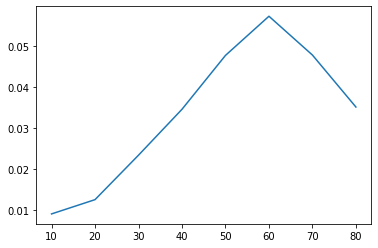

In [32]:
plt.plot(x_axis,kappas,label='pop_algo')

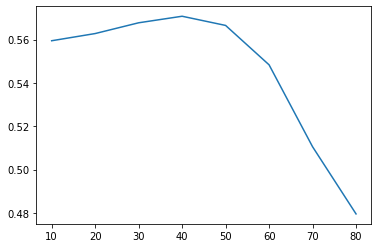

In [33]:
plt.plot(x_axis,accuracies,label='pop_algo')

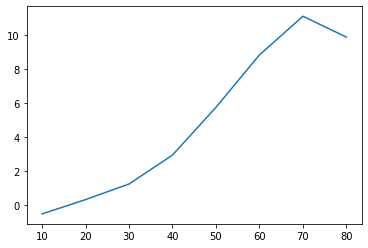

In [34]:
plt.plot(x_axis,pop_biases,label='pop_algo')

In [35]:
class PikiPopularityThresholdRecommender:
    
    MODEL_NAME = 'PikiPopularityThreshold'
    
    
    def __init__(self, test_df, train_df,threshold):
        self.test_df = test_df
        self.train_df = train_df
        self.threshold= threshold
        self.songs_by_piki_popularity=train_df.groupby('song_id')['liked'].mean()
        
    def get_model_name(self):
        return self.MODEL_NAME
     
    def classify_items(self, user_id, song_popularity):
        
        recommendations_df = 0*song_popularity
        for ind in recommendations_df.index: 
            try:
                if self.songs_by_piki_popularity[ind]>self.threshold:
                    recommendations_df[ind]=1
                else:
                    recommendations_df[ind]=0   
            except:
                recommendations_df[ind]=0   
        return recommendations_df 



In [36]:
kappas=[]
accuracies=[]
pop_biases=[]
x_axis=(.10,.20,.30,.40,.50,.60,.70,.80,.90)
for i in x_axis:
    piki_threshold_model=PikiPopularityThresholdRecommender(test_df,train_df,i)
    accuracy,kappa,pop_bias,global_metrics,people_metrics=model_evaluator.evaluate_model(piki_threshold_model)
    kappas.append(kappa)
    accuracies.append(accuracy)
    pop_biases.append(pop_bias)
    

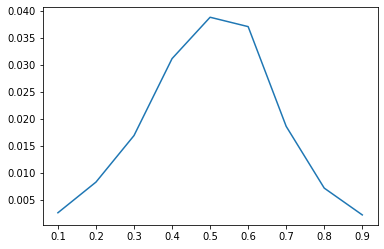

In [37]:
plt.plot(x_axis,kappas,label='piki_algo')

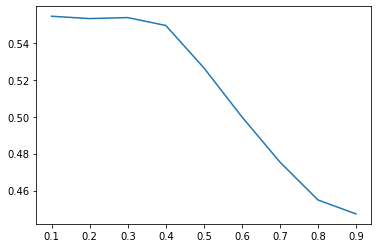

In [38]:
plt.plot(x_axis,accuracies,label='piki_algo')

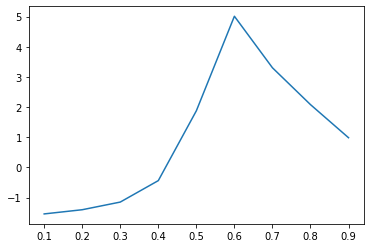

In [39]:
plt.plot(x_axis,pop_biases,label='piki_algo')

# SVM

In [414]:
from scipy.sparse import coo_matrix
# map each artist and user to a unique numeric value
train_df['user_id'] = train_df['user_id'].astype("category")
train_df['song_id'] = train_df['song_id'].astype("category")

# create a sparse matrix of all the artist/user/play triples
plays = coo_matrix((train_df['liked'].astype(float), 
                   (train_df['song_id'].cat.codes, 
                    train_df['user_id'].cat.codes)))
plays

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<17355x2065 sparse matrix of type '<class 'numpy.float64'>'
	with 283112 stored elements in COOrdinate format>